# The art of using t-SNE for single-cell transcriptomics. Tutorial

This tutorial uses the Allen institute VISp+ALM Smart-seq2 dataset from http://celltypes.brain-map.org/rnaseq/mouse. An earlier version of this dataset was described in https://www.biorxiv.org/content/early/2017/12/06/229542.

This notebook is self-contained. All functions that one needs to run this notebook are defined below.

Please install FIt-SNE from https://github.com/KlugerLab/FIt-SNE.

In [1]:
# Prepare

%matplotlib notebook

import numpy as np
import pylab as plt
import seaborn as sns; sns.set()
import pandas as pd
import pickle
import scipy
import matplotlib
from scipy import sparse
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import MDS

# import tsne
import sys; sys.path.append('/home/localadmin/github/FIt-SNE')
from fast_tsne import fast_tsne

# convenient data format
from collections import namedtuple
RNAseqData = namedtuple('RNAseqData', 'counts genes areas clusters clusterColors clusterNames')

In [2]:
print('Python version', sys.version)
print('Numpy', np.__version__)
print('Matplotlib', matplotlib.__version__)
print('Seaborn', sns.__version__)
print('Pandas', pd.__version__)
print('Scipy', scipy.__version__)
print('Sklearn', sklearn.__version__)

Python version 3.6.6 |Anaconda custom (64-bit)| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
Numpy 1.15.3
Matplotlib 3.0.0
Seaborn 0.8.0
Pandas 0.23.4
Pickle 4.0
Scipy 1.1.0
Sklearn 0.20.0


## Step 0. Load the data
Download the data from here: http://celltypes.brain-map.org/rnaseq and unpack. Direct links:
 * VISp: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413985
 * ALM: http://celltypes.brain-map.org/api/v2/well_known_file_download/694413179

To get the information about cluster colors and labels (`sample_heatmap_plot_data.csv`), open the interactive data browser http://celltypes.brain-map.org/rnaseq/mouse, go to "Sample Heatmaps", click "Build Plot!" and then "Download data as CSV".

In [4]:
%%time

# Load the Allen institute data. This takes a bit of time but saves the result 
# to a .pickle file that can be quickly loaded afterwards

# This function is needed because using Pandas to load these files in one go 
# can eat up a lot of RAM. So we are doing it in chunks, and converting each
# chunk to the sparse matrix format on the fly.
def sparseload(filename):
    with open(filename) as file:
        genes = []
        sparseblocks = []
        for i,chunk in enumerate(pd.read_csv(filename, chunksize=1000, index_col=0)):
            print('.', end='', flush=True)
            if i==0:
                cells = np.array(chunk.columns)
            genes.extend(list(chunk.index))
            sparseblock = sparse.csr_matrix(chunk.values.astype(float))
            sparseblocks.append([sparseblock])
        counts = sparse.bmat(sparseblocks)
        print(' done')
    return (counts.T, np.array(genes), cells)

filename = '../data/allen-visp-alm/mouse_VISp_2018-06-14_exon-matrix.csv'
counts1, genes, cells1 = sparseload(filename)

filename = '../data/allen-visp-alm/mouse_ALM_2018-06-14_exon-matrix.csv'
counts2, genes2, cells2 = sparseload(filename)

counts = sparse.vstack((counts1, counts2), format='csc')
counts1, counts2 = [], []
cells = np.concatenate((cells1, cells2))
assert(np.all(genes==genes2))

genesDF = pd.read_csv('../data/allen-visp-alm/mouse_VISp_2018-06-14_genes-rows.csv')
ids     = genesDF['gene_entrez_id'].tolist()
symbols = genesDF['gene_symbol'].tolist()
id2symbol = dict(zip(ids, symbols))
genes = np.array([id2symbol[g] for g in genes])

clusterInfo = pd.read_csv('../data/allen-visp-alm/sample_heatmap_plot_data.csv')
goodCells  = clusterInfo['sample_name'].values
ids        = clusterInfo['cluster_id'].values
labels     = clusterInfo['cluster_label'].values
colors     = clusterInfo['cluster_color'].values

clusterNames  = np.array([labels[ids==i+1][0] for i in range(np.max(ids))])
clusterColors = np.array([colors[ids==i+1][0] for i in range(np.max(ids))])
clusters   = np.copy(ids) - 1

ind = np.array([np.where(cells==c)[0][0] for c in goodCells])
counts = counts[ind, :]

areas = (ind < cells1.size).astype(int)

tasic2018 = RNAseqData(counts=counts, genes=genes, clusters=clusters, areas=areas, 
                       clusterColors=clusterColors, clusterNames = clusterNames)

pickle.dump(tasic2018, open('../data/allen-visp-alm/tasic2018.pickle', 'wb'))

.............................................. done
.............................................. done
CPU times: user 4min 19s, sys: 11.5 s, total: 4min 30s
Wall time: 4min 33s


In [2]:
# The above cell needs to be run only once. Then one can load the data 
# from the .pickle file which is much faster

tasic2018 = pickle.load(open('../data/allen-visp-alm/tasic2018.pickle', 'rb'))

print('Number of cells:', tasic2018.counts.shape[0])
print('Number of cells from ALM:', np.sum(tasic2018.areas==0))
print('Number of cells from VISp:', np.sum(tasic2018.areas==1))
print('Number of clusters:', np.unique(tasic2018.clusters).size)
print('Number of genes:', tasic2018.counts.shape[1])
print('Fraction of zeros in the data matrix: {:.2f}'.format(tasic2018.counts.size/np.prod(tasic2018.counts.shape)))

Number of cells: 23822
Number of cells from ALM: 9573
Number of cells from VISp: 14249
Number of clusters: 133
Number of genes: 45768
Fraction of zeros in the data matrix: 0.20


## Step 1. Pre-processing

<IPython.core.display.Javascript object>


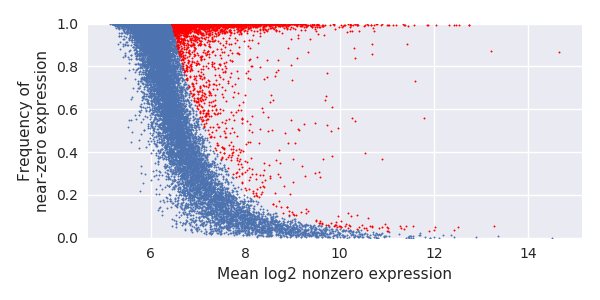

CPU times: user 33.2 s, sys: 4.1 s, total: 37.3 s
Wall time: 37.3 s


In [3]:
%%time

# Feature selection

def nearZeroRate(data, threshold=0):
    zeroRate = 1 - np.squeeze(np.array((data>threshold).mean(axis=0)))
    return zeroRate

def meanLogExpression(data, threshold=0, atleast=10):
    nonZeros = np.squeeze(np.array((data>threshold).sum(axis=0)))
    N = data.shape[0]
    A = data.multiply(data>threshold)
    A.data = np.log2(A.data)
    meanExpr = np.zeros(data.shape[1]) * np.nan
    detected = nonZeros >= atleast
    meanExpr[detected] = np.squeeze(np.array(A[:,detected].mean(axis=0))) / (nonZeros[detected]/N)
    return meanExpr
    
def featureSelection(meanLogExpression, nearZeroRate, yoffset=.02, n=3000):
    low = 0; up=10    
    nonan = ~np.isnan(meanLogExpression)
    xoffset = 5
    for step in range(100):
        selected = np.zeros_like(nearZeroRate).astype(bool)
        selected[nonan] = nearZeroRate[nonan] > np.exp(-meanLogExpression[nonan] + xoffset) + yoffset
        if np.sum(selected) == n:
            break
        elif np.sum(selected) < n:
            up = xoffset
            xoffset = (xoffset + low)/2
        else:
            low = xoffset
            xoffset = (xoffset + up)/2
    return selected

x = meanLogExpression(tasic2018.counts, threshold=32)  # Get mean log non-zero expression of each gene
y = nearZeroRate(tasic2018.counts, threshold=32)       # Get near-zero frequency of each gene
selectedGenes = featureSelection(x, y, n=3000)         # Adjust the threshold to select 3000 genes

plt.figure(figsize=(6,3))
plt.scatter(x[~selectedGenes], y[~selectedGenes], s=1)
plt.scatter(x[selectedGenes],  y[selectedGenes], s=1, color='r')
plt.xlabel('Mean log2 nonzero expression')
plt.ylabel('Frequency of\nnear-zero expression')
plt.ylim([0,1])
plt.tight_layout()

In [4]:
%%time

counts3k = tasic2018.counts[:, selectedGenes]  # Feature selection

librarySizes = tasic2018.counts.sum(axis=1)    # Compute library sizes
CPM = counts3k / librarySizes * 1e+6           # Library size normalisation

logCPM = np.log2(CPM + 1)                      # Log-transformation

X = PCA(n_components=50).fit_transform(logCPM) # PCA

print('Shape of the resulting matrix:', X.shape, '\n')

Shape of the resulting matrix: (23822, 50) 

CPU times: user 11.2 s, sys: 1.4 s, total: 12.6 s
Wall time: 5.01 s


## Step 2. Initial data exploration using PCA 

<IPython.core.display.Javascript object>


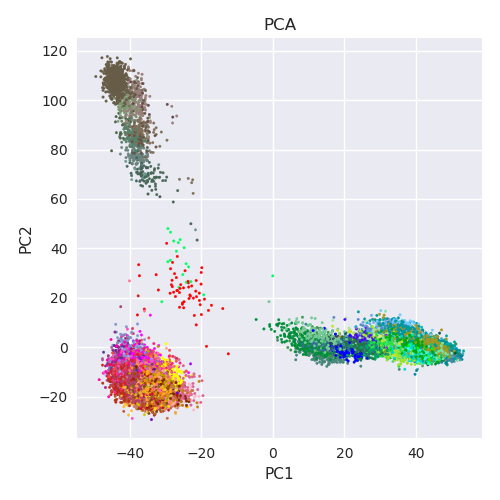

In [10]:
# Principal component analysis

plt.figure(figsize=(5,5))
plt.scatter(X[:,0], X[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
plt.title('PCA')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

<IPython.core.display.Javascript object>


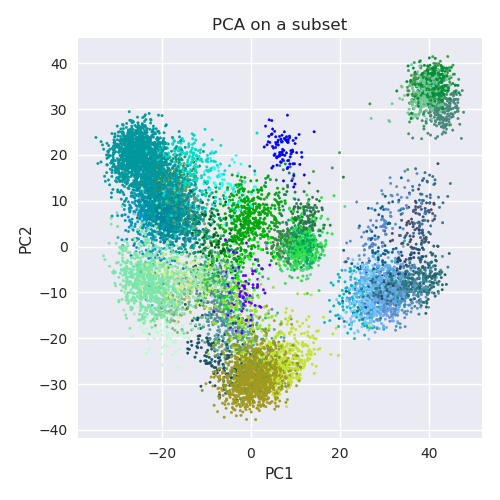

CPU times: user 964 ms, sys: 8 ms, total: 972 ms
Wall time: 313 ms


In [11]:
%%time

# Principal component analysis on a subset identified on the previous figure

subset = X[:,0] > -8
Xsubset = PCA(n_components=2).fit_transform(X[subset,:])

plt.figure(figsize=(5,5))
plt.scatter(Xsubset[:,0], Xsubset[:,1], s=3, 
            color=tasic2018.clusterColors[tasic2018.clusters[subset]])
plt.title('PCA on a subset')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()

<IPython.core.display.Javascript object>


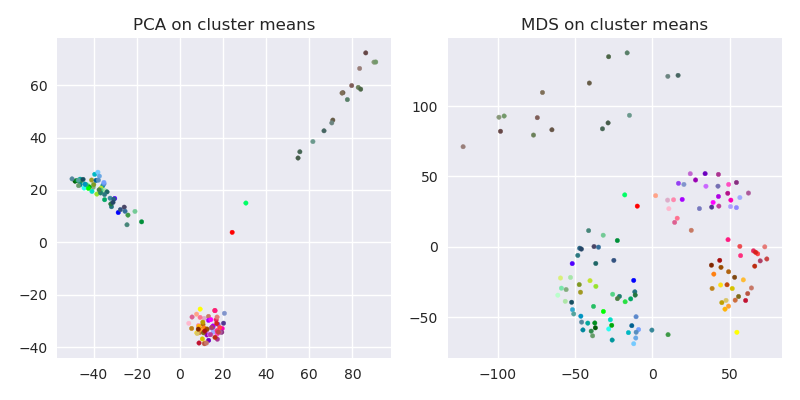

CPU times: user 1.82 s, sys: 28 ms, total: 1.85 s
Wall time: 493 ms


In [12]:
%%time

# If clustering results are available, do PCA and/or MDS on the cluster means

C = np.unique(tasic2018.clusters).size
clusterMeans = np.zeros((C, X.shape[1]))
for c in range(C):
    clusterMeans[c,:] = np.mean(X[tasic2018.clusters==c,:], axis=0)

clusterMeansPCA = PCA(n_components=2).fit_transform(clusterMeans)
clusterMeansMDS = MDS(n_components=2, random_state=1).fit_transform(clusterMeans)

plt.figure(figsize=(8,4))
plt.subplot(121)
plt.scatter(clusterMeansPCA[:,0], clusterMeansPCA[:,1], s=10, color=tasic2018.clusterColors)
plt.title('PCA on cluster means')
plt.subplot(122)
plt.scatter(clusterMeansMDS[:,0], clusterMeansMDS[:,1], s=10, color=tasic2018.clusterColors)
plt.title('MDS on cluster means')
plt.tight_layout()

## Step 3. Creating a standard t-SNE visualisation 

CPU times: user 36 ms, sys: 96 ms, total: 132 ms
Wall time: 35.9 s


<IPython.core.display.Javascript object>


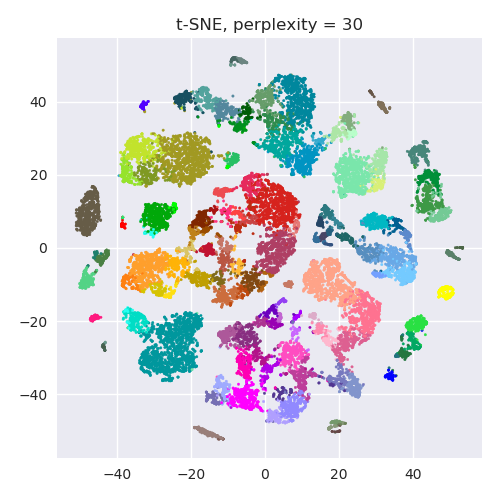

In [13]:
# This uses perplexity=30 (default) and random initialisation

%time tsne30 = fast_tsne(X)  

plt.figure(figsize=(5,5))
plt.scatter(tsne30[:,0], tsne30[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
plt.title('t-SNE, perplexity = 30')
plt.tight_layout()

## Step 4. Exploring the dataset at different scales

<IPython.core.display.Javascript object>


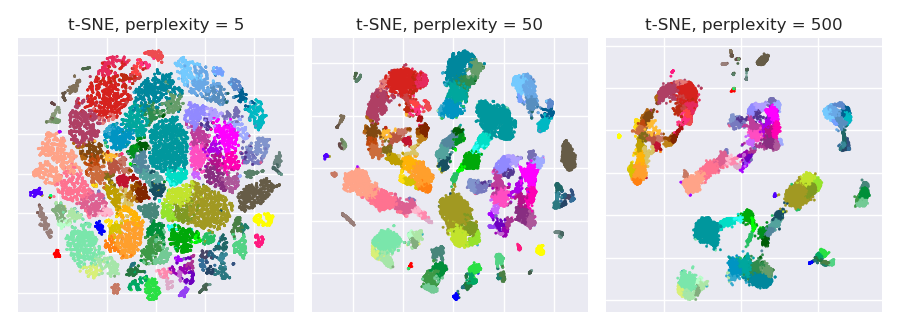

CPU times: user 1.08 s, sys: 280 ms, total: 1.36 s
Wall time: 3min 49s


In [14]:
%%time

tsne5   = fast_tsne(X, perplexity=5,   seed=42)
tsne50  = fast_tsne(X, perplexity=50,  seed=42)
tsne500 = fast_tsne(X, perplexity=500, seed=42)

tsnes  = [tsne5, tsne50, tsne500]
titles = [5, 50, 500]

plt.figure(figsize=(9,3.3))
for i,t in enumerate(tsnes):
    plt.subplot(1,3,i+1)
    plt.scatter(tsnes[i][:,0], tsnes[i][:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
    plt.title('t-SNE, perplexity = ' + str(titles[i]))
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

The cell below runs t-SNE with different fixed kernel widths (i.e. without perplexity calibration).

<IPython.core.display.Javascript object>


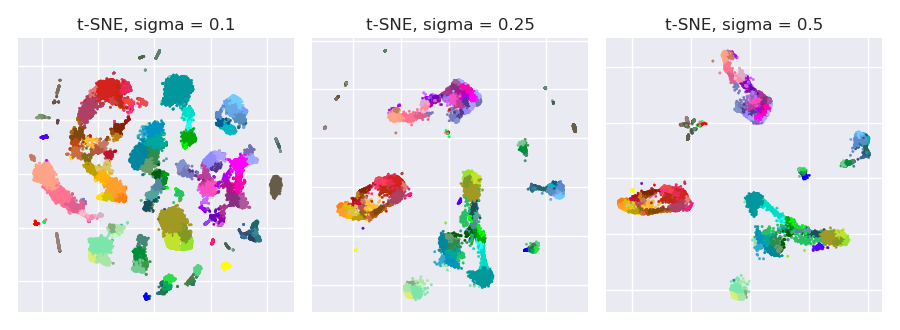

CPU times: user 1.14 s, sys: 276 ms, total: 1.41 s
Wall time: 6min 12s


In [15]:
%%time 

# Here we use X/np.max(np.abs(X)) as input to t-SNE so that sigma values are more interpretable

tsne01  = fast_tsne(X/np.max(np.abs(X)), sigma=0.1,  K=1000, seed=42)
tsne025 = fast_tsne(X/np.max(np.abs(X)), sigma=0.25, K=1000, seed=42)
tsne05  = fast_tsne(X/np.max(np.abs(X)), sigma=0.5,  K=1000, seed=42)

tsnes  = [tsne01, tsne025, tsne05]
titles = [0.1, 0.25, 0.5]

plt.figure(figsize=(9,3.3))
for i,t in enumerate(tsnes):
    plt.subplot(1,3,i+1)
    plt.scatter(tsnes[i][:,0], tsnes[i][:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
    plt.title('t-SNE, sigma = ' + str(titles[i]))
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

Small sigmas (left panel) are similar to small perplexities: each point is only attracted to the closest neighbours. Large sigmas (right panel) are similar to large perplexities: each point is similarly attracted to all $K=1000$ neighbours. The interesting case are some intermediate values (middle pabel).

## Step 5. Refining the t-SNE visualisation 
Here we use scaled PCA as initialisation and the default perplexity (30).

<IPython.core.display.Javascript object>


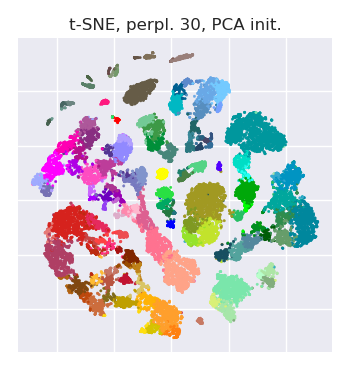

CPU times: user 364 ms, sys: 80 ms, total: 444 ms
Wall time: 35.5 s


In [13]:
%%time

PCAinit = X[:,:2] / np.std(X[:,0]) * 0.0001
tsne30pca = fast_tsne(X, initialization=PCAinit)

plt.figure(figsize=(3.5,3.7))
plt.scatter(tsne30pca[:,0], tsne30pca[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
plt.title('t-SNE, perpl. 30, PCA init.')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

Here we use scaled PCA initialisation and perplexity combination of 50 and 500.

<IPython.core.display.Javascript object>


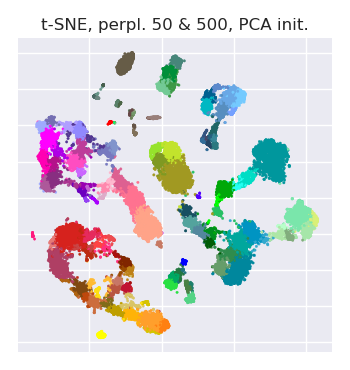

CPU times: user 412 ms, sys: 80 ms, total: 492 ms
Wall time: 2min 42s


In [5]:
%%time

PCAinit = X[:,:2] / np.std(X[:,0]) * 0.0001
tsne50_500 = fast_tsne(X, perplexity_list=[50,500], initialization=PCAinit)

plt.figure(figsize=(3.5,3.7))
plt.scatter(tsne50_500[:,0], tsne50_500[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters])
plt.title('t-SNE, perpl. 50 & 500, PCA init.')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

## Step 6. Mapping new cells to an existing visualisation (optional)
We randomly select 100 cells as a "test set" and use all other cells as the "training set". We map the test set onto the t-SNE done on the training set.

In [14]:
# We use correlation across 3000 genes as the similarity metric to map test set points
# In this case we could use Euclidean distance as well, but in general correlaion should be
# more robust against possible batch effects, when mapping cells from other experiments

# This function is NOT an effective implementation and is used here for demonstration purposes
# only. Please use our function from rnaseqTools.py for a more efficient implementation

def map_to_tsne(referenceCounts, newCounts, referenceAtlas, knn = 25):
    referenceCounts = np.array(np.log2(referenceCounts.todense() + 1))
    newCounts = np.array(np.log(newCounts.todense() + 1))

    # Computing the matrix of correlations
    def corr2(A,B):
        A = A - A.mean(axis=1, keepdims=True)
        B = B - B.mean(axis=1, keepdims=True)
        ssA = (A**2).sum(axis=1, keepdims=True)
        ssB = (B**2).sum(axis=1, keepdims=True)
        C = np.dot(A, B.T) / np.sqrt(np.dot(ssA,ssB.T))
        return C
    
    C = corr2(newCounts, referenceCounts)
        
    assignmentPositions = np.zeros((newCounts.shape[0], 2))
    for i in range(newCounts.shape[0]):
        ind = np.argsort(C[i,:])[::-1][:knn]                 
        assignmentPositions[i,:] = np.median(referenceAtlas[ind,:], axis=0)

    return assignmentPositions

In [6]:
%%time

# Randomly select 100 points as the test set
testSet     = np.random.choice(X.shape[0], 100)
trainingSet = np.array([i for i in range(X.shape[0]) if i not in testSet])

# Run t-SNE on the training set
Xtrain = PCA(n_components=50).fit_transform(logCPM[trainingSet,:])
PCAinit_train = Xtrain[:,:2] / np.std(Xtrain[:,0]) * 0.0001
tsneTrain = fast_tsne(Xtrain, perplexity_list=[50,500], initialization=PCAinit_train)

CPU times: user 8.44 s, sys: 748 ms, total: 9.18 s
Wall time: 2min 43s


In [7]:
%%time

# Map test points to the training t-SNE
pos = map_to_tsne(tasic2018.counts[:,selectedGenes][trainingSet,:],
                  tasic2018.counts[:,selectedGenes][testSet,:],
                  tsneTrain)

CPU times: user 2.44 s, sys: 1.08 s, total: 3.51 s
Wall time: 2.58 s


<IPython.core.display.Javascript object>


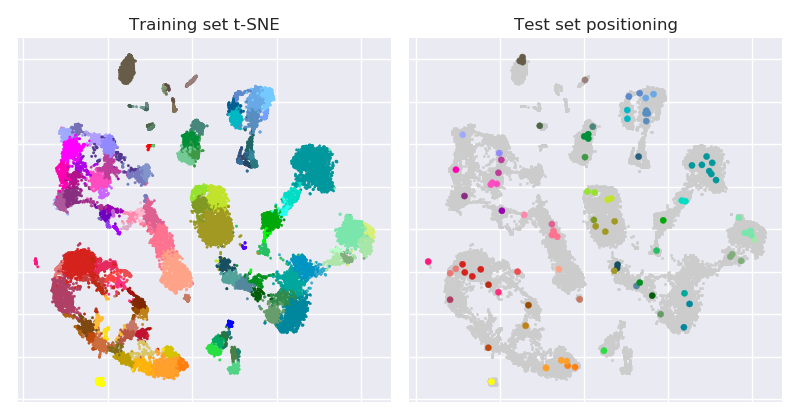

In [8]:
# Plot

plt.figure(figsize=(8,4.2))

plt.subplot(121)
plt.scatter(tsneTrain[:,0], tsneTrain[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters[trainingSet]])
plt.title('Training set t-SNE')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

plt.subplot(122)
plt.scatter(tsneTrain[:,0], tsneTrain[:,1], s=3, color=[.8,.8,.8])
plt.scatter(pos[:,0], pos[:,1], s=20, color=tasic2018.clusterColors[tasic2018.clusters[testSet]])
plt.title('Test set positioning')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

## Step 7. Creating aligned t-SNE visualisations (optional)
We randomly select 5000 cells as a "data set 1" and use all other cells as the "data set 2". We perform t-SNE of the first data set, then map the second data set on the resulting t-SNE and use this mapping as initialisation to run t-SNE on the second dataset.

In [9]:
%%time

# Randomly select 5000 points as one dataset and the rest as another

set1 = np.random.choice(X.shape[0], 5000)
set2 = np.array([i for i in range(X.shape[0]) if i not in set1])

# Run t-SNE on data set 1

X1 = PCA(n_components=50).fit_transform(logCPM[set1,:])
PCAinit1 = X1[:,:2] / np.std(X1[:,0]) * 0.0001
tsne1 = fast_tsne(X1, perplexity=50, initialization=PCAinit1)

# Map data set 2 to this t-SNE

pos = map_to_tsne(tasic2018.counts[:,selectedGenes][set1,:],
                  tasic2018.counts[:,selectedGenes][set2,:],
                  tsne1)

# Run t-SNE of data set 2

X2 = PCA(n_components=50).fit_transform(logCPM[set2,:])
tsne2 = fast_tsne(X2, perplexity_list=[50,500], initialization=pos)

CPU times: user 31.7 s, sys: 2.76 s, total: 34.5 s
Wall time: 3min 44s


<IPython.core.display.Javascript object>


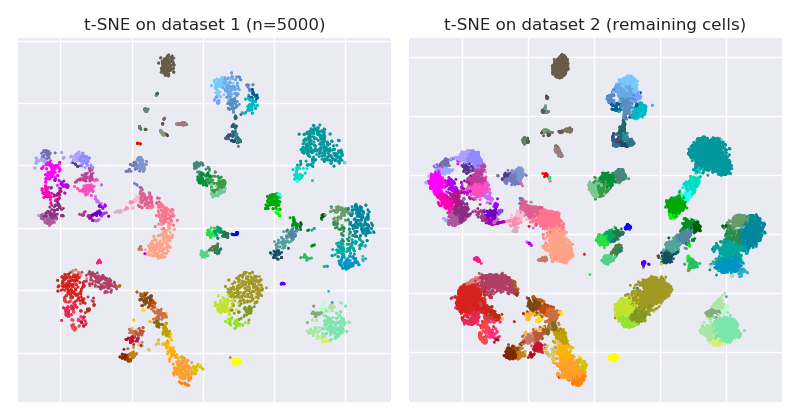

In [165]:
plt.figure(figsize=(8,4.2))

plt.subplot(121)
plt.scatter(tsne1[:,0], tsne1[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters[set1]])
plt.title('t-SNE on dataset 1 (n=5000)')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

plt.subplot(122)
plt.scatter(tsne2[:,0], tsne2[:,1], s=3, color=tasic2018.clusterColors[tasic2018.clusters[set2]])
plt.title('t-SNE on dataset 2 (remaining cells)')
plt.gca().get_xaxis().set_ticklabels([])
plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

## Step 8: Dealing with large data sets (optional)
Here we create a simulate large dataset by replicating each cell in the Tasic et al. data 10 times and adding Gaussian noise in the space of the first 50 PCs. The resulting dataset has N = 238 thousand cells. We assume that this dataset is of such size that we cannot use any perplexity that is much larger than default (30). So we are only using default perplexity here.

Our approach uses downsampling-based initialisation. Here we will use t-SNE of the actual Tasic et al. dataset as initialisation (we have just upsampled it, so no need to explicitly downsample). For real data one would use a downsampled version of the actual data.

In [10]:
# Simulate the dataset

X10x = X.copy()
cl10x = tasic2018.clusters.copy()
for i in range(9):
    X10x = np.concatenate((X10x,X))
    cl10x = np.concatenate((cl10x, tasic2018.clusters))
X10x = X10x + np.random.randn(*X10x.shape) * 1.5

print('Simulated dataset size:', X10x.shape)

Simulated dataset size: (238220, 50)


In [11]:
# This uses Euclidean distance, only 1 nearest neighbor, and computes 
# positioning in batches of 1000 cells to avoid computing an enormous matrix

def map_to_tsne_fast(referenceData, newData, referenceAtlas, batchsize=1000):
    steps = int(np.floor(newData.shape[0]/batchsize) + 1)
    assignmentPositions = np.zeros((newData.shape[0], 2))
    for i in range(steps):
        print('.', end='', flush=True)
        if i>1 and i%100==0:
            print('', flush=True)
        endind = np.min(((i+1)*batchsize, newData.shape[0]))
        
        def pdist2(A,B):
            return np.sum(A**2,axis=1,keepdims=True) + np.sum(B**2, axis=1, keepdims=True).T - 2*A@B.T
        
        D = pdist2(referenceData, newData[i*batchsize:endind, :])
        m = np.argmin(D, axis=0)
        assignmentPositions[i*batchsize:endind] = referenceAtlas[m,:]
    print(' done', flush=True)
    return assignmentPositions

In [12]:
# Default t-SNE with PCA initialisation
PCAinit10x = X10x[:,:2] / np.std(X10x[:,0]) * 0.0001
%time tsne10x = fast_tsne(X10x, initialization=PCAinit10x)

# t-SNE with exaggeration=4 and PCA initialisation
%time tsne10x_ex = fast_tsne(X10x, initialization=PCAinit10x, late_exag_coeff=4, start_late_exag_iter=250)

# t-SNE with exaggeration=4 and downsampling-based initialisation
%time pos = map_to_tsne_fast(X, X10x, tsne50_500)
downsampled_init = pos / np.std(pos[:,0]) * 0.0001
%time tsne10x_pos = fast_tsne(X10x, initialization = downsampled_init, late_exag_coeff=4, start_late_exag_iter=250)

CPU times: user 280 ms, sys: 180 ms, total: 460 ms
Wall time: 2min 46s
CPU times: user 320 ms, sys: 172 ms, total: 492 ms
Wall time: 2min 44s
.....................................................................................................
....................................................................................................
...................................... done
CPU times: user 3min 31s, sys: 37.9 s, total: 4min 9s
Wall time: 1min 31s
CPU times: user 732 ms, sys: 164 ms, total: 896 ms
Wall time: 2min 45s


<IPython.core.display.Javascript object>


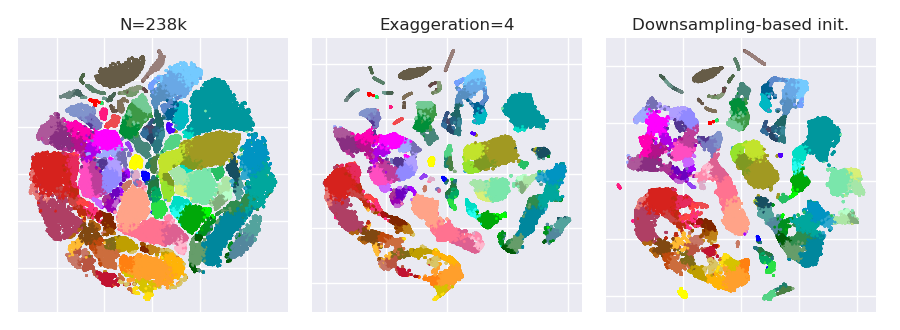

In [248]:
# Plot

tsnes  = [tsne10x, tsne10x_ex, tsne10x_pos]
titles = ['N=238k', 'Exaggeration=4', 'Downsampling-based init.']

plt.figure(figsize=(9,3.3))
for i,t in enumerate(tsnes):
    plt.subplot(1,3,i+1)
    plt.scatter(tsnes[i][:,0], tsnes[i][:,1], s=3, color=tasic2018.clusterColors[cl10x])
    plt.title(titles[i])
    plt.gca().get_xaxis().set_ticklabels([])
    plt.gca().get_yaxis().set_ticklabels([])
plt.tight_layout()

Note how on panel B the yellow cluster (SSt.Chodl) is in the middle of the figure,
even though it actually should be close to the orange (SSt) continent. Using our
downsampling-based initialisastion helps to get this right.